![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz
import matplotlib.pyplot as plt

In [3]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [14]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

## Análisis

En general, se identifica que hay una mayor cantidad de alquileres en promedio en los dias laborales vs los dias no laborales, sin embargo, aun es necesario descartar aquellos dias considerados laborales (Lunes a Viernes) que son feriados.

In [5]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

## Análisis

Se idenfica que las horas de mayor demanda coinciden con las horas de entrada y salida tradicionales de los trabajos [7AM-9AM], [12-1PM], [5-6PM], esto considerando que posiblemente las personas que se desplazan desde o hacia sus lugares de trabajo, tambien estén utilizando el servicio de alquiler de bicicletas.

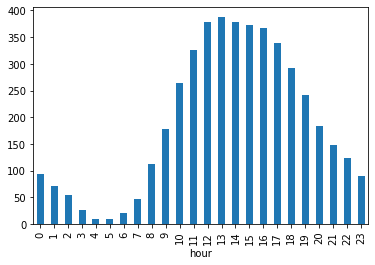

In [17]:
#Análisis del comportamiento por hora en dias NO laborales
bikes[bikes['workingday']==0].groupby('hour').total.mean().plot.bar()

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

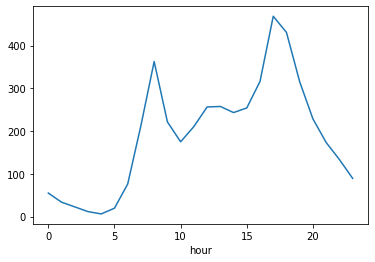

In [18]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

## Análisis

Debido a que 5 de cada 7 días son considerados como laborables, la distribución general de estos datos es muy similar a la distribución o el comportamiento encontrado en la grafica de la celda 2.3, en donde se analizan exclusivamente estos dias.

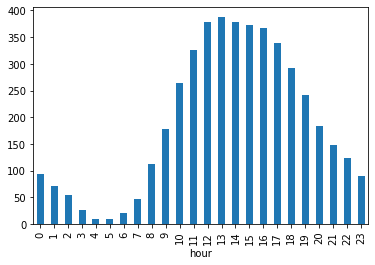

In [24]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 

bikes[bikes['workingday']==0].groupby('hour').total.mean().plot.bar()

## Análisis

En los días NO laborales se logra visualizar un comportamiento mas estable durante todo el día, concentrando la mayor parte de la demanda entre las 10 de la mañana y las 7 de la noche.

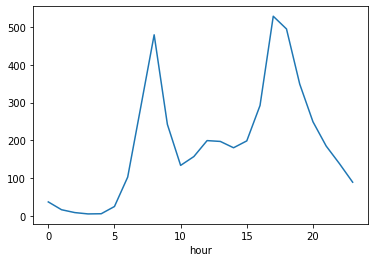

In [21]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 

bikes[bikes['workingday']==1].groupby('hour').total.mean().plot()

## Análisis

Al tener un comportamiento muy similar al encontrado en lso datos generalizados, es posible determinar que la demanda en los dias laborales se concentra principalmente en los horarios de desplazamiento desde y hacia los sitios de trabajo, esto a partir de los horarios de los alquileres.

### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [35]:
# Celda 3
X = bikes[['hour', 'workingday']]
Y = bikes[['total']]
regresion = LinearRegression()  
regresion.fit(X, Y) 
regresion.coef_

array([[10.49206282,  4.07248627]])

### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [116]:
# Definición de la función que calcula el gini index
def gini(y):
    if y.shape[0] == 0:
        return 0
    else:
        return 1 - (y.mean()**2 + (1 - y.mean())**2)

# Definición de la función gini_imputiry para calular la ganancia de una variable predictora j dado el punto de corte k
def gini_impurity(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    y_r = y.loc[~filter_l]
    
    n_l = y_l.shape[0]
    n_r = y_r.shape[0]
    
    gini_y = gini(y)
    gini_l = gini(y_l)
    gini_r = gini(y_r)
    
    gini_impurity_ = gini_y - (n_l / (n_l + n_r) * gini_l + n_r / (n_l + n_r) * gini_r)
    
    return gini_impurity_


# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    
    features = range(X.shape[1])
    
    bs = [0, 0, 0]  # j, split, gain
    
    # Para todas las varibles 
    for j in features:
        
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        
        # Para cada partición
        for split in splits:
          try:
            gain = gini_impurity(X.iloc[:, j], y, split)
            if gain > bs[2]:
              bs = [j, split, gain]
          except:
            print(f'falla:{gain}')
    
    return bs

  # Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], y_prob=0.5, level=level, split=-1, n_samples=1, gain=0)
        return tree
    
    # Calcular la mejor división
    j, split, gain = best_split(X, y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = int(y.mean() >= 0.5) 
    y_prob = (y.sum() + 1.0) / (y.shape[0] + 2.0)  # Corrección Laplace 
    
    tree = dict(y_pred=y_pred, y_prob=y_prob, level=level, split=-1, n_samples=X.shape[0], gain=gain)
    # Revisar el criterio de parada 
    if gain < min_gain:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth, num_pct=num_pct)
    
    return tree

def tree_predict(X, tree, proba=False):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        if not proba:
            predicted = predicted * tree['y_pred']
        else:
            predicted = predicted * tree['y_prob']
            
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'], proba)
            predicted[~filter_l] = tree_predict(X_r, tree['sr'], proba)

    return predicted


def fnMSE(real, estimado):
  n = len(real)
  r = real - estimado 
  r = r ** 2
  r = np.sum(r) 
  return r / n

In [98]:
class NodeRegression():
    """
    Clase para estimar un arbol de forma iterativa
    """
    def __init__(
        self, 
        Y: list,
        X: pd.DataFrame,
        min_samples_split=None,
        max_depth=None,
        depth=None,
        node_type=None,
        rule=None
    ):
        # Saving the data to the node 
        self.Y = Y 
        self.X = X

        # Saving the hyper parameters
        self.min_samples_split = min_samples_split if min_samples_split else 20
        self.max_depth = max_depth if max_depth else 5

        # Default current depth of node 
        self.depth = depth if depth else 0

        # Extracting all the features
        self.features = list(self.X.columns)

        # Type of node 
        self.node_type = node_type if node_type else 'root'

        # Rule for spliting 
        self.rule = rule if rule else ""

        # Getting the mean of Y 
        self.ymean = np.mean(Y)

        # Getting the residuals 
        self.residuals = self.Y - self.ymean

        # Calculating the mse of the node 
        self.mse = self.get_mse(Y, self.ymean)

        # Saving the number of observations in the node 
        self.n = len(Y)

        # Initiating the left and right nodes as empty nodes
        self.left = None 
        self.right = None 

        # Default values for splits
        self.best_feature = None 
        self.best_value = None 

    @staticmethod
    def get_mse(ytrue, yhat) -> float:
        """
        Calcular MSE 
        """
        # Getting the total number of samples
        n = len(ytrue)

        # Getting the residuals 
        r = ytrue - yhat 

        # Squering the residuals 
        r = r ** 2

        # Suming 
        r = np.sum(r)

        # Getting the average and returning 
        return r / n

    @staticmethod
    def ma(x: np.array, window: int) -> np.array:
        """
        Calcula la media movil 
        """
        return np.convolve(x, np.ones(window), 'valid') / window

    def best_split(self) -> tuple:
        """
        Dadas las predictoras y la variable a predecir, se estima la mejor forma de partir los valores.
        """
        # Creating a dataset for spliting
        df = self.X.copy()
        df['Y'] = self.Y

        # Getting the GINI impurity for the base input 
        mse_base = self.mse

        # Finding which split yields the best GINI gain 
        #max_gain = 0

        # Default best feature and split
        best_feature = None
        best_value = None

        for feature in self.features:
            # Droping missing values
            Xdf = df.dropna().sort_values(feature)

            # Sorting the values and getting the rolling average
            xmeans = self.ma(Xdf[feature].unique(), 2)

            for value in xmeans:
                # Getting the left and right ys 
                left_y = Xdf[Xdf[feature]<value]['Y'].values
                right_y = Xdf[Xdf[feature]>=value]['Y'].values

                # Getting the means 
                left_mean = np.mean(left_y)
                right_mean = np.mean(right_y)

                # Getting the left and right residuals 
                res_left = left_y - left_mean 
                res_right = right_y - right_mean

                # Concatenating the residuals 
                r = np.concatenate((res_left, res_right), axis=None)

                # Calculating the mse 
                n = len(r)
                r = r ** 2
                r = np.sum(r)
                mse_split = r / n

                # Checking if this is the best split so far 
                if mse_split < mse_base:
                    best_feature = feature
                    best_value = value 

                    # Setting the best gain to the current one 
                    mse_base = mse_split

        return (best_feature, best_value)

    def grow_tree(self):
        """
        Recursive method to create the decision tree
        """
        # Making a df from the data 
        df = self.X.copy()
        df['Y'] = self.Y

        # If there is GINI to be gained, we split further 
        if (self.depth < self.max_depth) and (self.n >= self.min_samples_split):

            # Getting the best split 
            best_feature, best_value = self.best_split()

            if best_feature is not None:
                # Saving the best split to the current node 
                self.best_feature = best_feature
                self.best_value = best_value

                # Getting the left and right nodes
                left_df, right_df = df[df[best_feature]<=best_value].copy(), df[df[best_feature]>best_value].copy()

                # Creating the left and right nodes
                left = NodeRegression(
                    left_df['Y'].values.tolist(), 
                    left_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split, 
                    node_type='left_node',
                    rule=f"{best_feature} <= {round(best_value, 3)}"
                    )

                self.left = left 
                self.left.grow_tree()

                right = NodeRegression(
                    right_df['Y'].values.tolist(), 
                    right_df[self.features], 
                    depth=self.depth + 1, 
                    max_depth=self.max_depth, 
                    min_samples_split=self.min_samples_split,
                    node_type='right_node',
                    rule=f"{best_feature} > {round(best_value, 3)}"
                    )

                self.right = right
                self.right.grow_tree()

    def print_info(self, width=4):
        """
        Method to print the infromation about the tree
        """
        # Defining the number of spaces 
        const = int(self.depth * width ** 1.5)
        spaces = "-" * const
        
        if self.node_type == 'root':
            print("Root")
        else:
            print(f"|{spaces} Split rule: {self.rule}")
        print(f"{' ' * const}   | MSE of the node: {round(self.mse, 2)}")
        print(f"{' ' * const}   | Count of observations in node: {self.n}")
        print(f"{' ' * const}   | Prediction of node: {round(self.ymean, 3)}")   

    def print_tree(self):
        """
        Prints the whole tree from the current node to the bottom
        """
        self.print_info() 
        
        if self.left is not None: 
            self.left.print_tree()
        
        if self.right is not None:
            self.right.print_tree()

In [117]:
features = ['hour', 'workingday']
todas = ['hour', 'workingday', 'total']
for ft in todas:
    bikes[ft] = pd.to_numeric(bikes[ft])
X = X[features]
Y = bikes['total']

In [122]:
tree = tree_grow(X, Y, level=0, min_gain=0.001, max_depth=2, num_pct=5)
estimado = tree_predict(X, tree)

In [128]:
root = NodeRegression(Y.values.tolist(), X, max_depth=2, min_samples_split=5)
root.grow_tree()

In [129]:
# Celda 4
#Utilizando metodos iterativos y ajustando con MSE
root.print_tree()
#Utlizando la tecnica planteada en clase
tree

Root
   | MSE of the node: 32810.3
   | Count of observations in node: 10886
   | Prediction of node: 191.574
|-------- Split rule: hour <= 6.5
           | MSE of the node: 1565.56
           | Count of observations in node: 3139
           | Prediction of node: 32.582
|---------------- Split rule: hour <= 5.5
                   | MSE of the node: 945.78
                   | Count of observations in node: 2684
                   | Prediction of node: 25.178
|---------------- Split rule: hour > 5.5
                   | MSE of the node: 2990.46
                   | Count of observations in node: 455
                   | Prediction of node: 76.259
|-------- Split rule: hour > 6.5
           | MSE of the node: 31077.58
           | Count of observations in node: 7747
           | Prediction of node: 255.996
|---------------- Split rule: hour <= 20.5
                   | MSE of the node: 32410.31
                   | Count of observations in node: 6379
                   | Prediction of no

{'gain': 18268.811823533004,
 'level': 0,
 'n_samples': 10886,
 'sl': {'gain': 5401.416218294678,
  'level': 1,
  'n_samples': 3594,
  'sl': {'gain': 382.8088308604629,
   'level': 2,
   'n_samples': 2684,
   'split': -1,
   'y_pred': 1,
   'y_prob': 25.15934475055845},
  'split': [0, 6.0],
  'sr': {'gain': 11537.911994799186,
   'level': 2,
   'n_samples': 910,
   'split': -1,
   'y_pred': 1,
   'y_prob': 144.37171052631578},
  'y_pred': 1,
  'y_prob': 55.40711902113459},
 'split': [0, 8.0],
 'sr': {'gain': 7392.920792160614,
  'level': 1,
  'n_samples': 7292,
  'sl': {'gain': 5136.949194485263,
   'level': 2,
   'n_samples': 5924,
   'split': -1,
   'y_pred': 1,
   'y_prob': 287.7910901113736},
  'split': [0, 21.0],
  'sr': {'gain': 1818.4488902568337,
   'level': 2,
   'n_samples': 1368,
   'split': -1,
   'y_pred': 1,
   'y_prob': 131.95985401459853},
  'y_pred': 1,
  'y_prob': 258.6007677543186},
 'y_pred': 1,
 'y_prob': 191.53903379867745}

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de clasificación y compare desempeño con el modelo del punto 3.

In [ ]:
# Celda 5


## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir la cantidad de reacciones en redes sociales (popularidad) de la notica. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [ ]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

In [ ]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

In [ ]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [ ]:
# Celda 6


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [ ]:
# Celda 7


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [ ]:
# Celda 8


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

In [ ]:
# Celda 9